In [213]:
#pip install plotnine

In [235]:
import pandas as pd
import numpy as np
from collections import defaultdict
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from plotnine.data import mtcars
import seaborn as sns
import os
from tqdm import tqdm

In [229]:
Master_Path = 'C:/Users/mdelan02/markov/'

data_path = 'Data'

In [267]:
os.chdir(Master_Path)
os.chdir(data_path)

remove_ls = []
for file in os.listdir():
    if '~$' in file: #remove temporary files
        remove_ls.append(file)
        os.remove(file)
print(remove_ls)
print(os.listdir())

[]
['attr1.csv', 'attr2.csv', 'attr3.csv', 'attr4.csv', 'attr5.csv', 'attr6.csv']


In [268]:
df = pd.DataFrame()
number_files = len(os.listdir())

In [269]:
for i in tqdm(range(number_files)):
    hold = pd.read_csv(os.listdir()[i])        
    df = df.append(hold)
    i += 1

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:01<00:00,  5.95it/s]


In [270]:
df.reset_index(inplace = True,drop=True)

In [274]:
#Wrote code to split the original data into chunks
#This is testing the data upload with the chunks is equal to the whole file

#os.chdir(Master_Path)
#df2 = pd.read_csv('attribution data.csv')

#df.equals(df2)

True

In [243]:
#Sort cookies into chronological order
df = df.sort_values(['cookie', 'time'],    
                    ascending=[False, True])

#assign visit order (cumcount starts at 0)
df['visit_order'] = df.groupby('cookie').cumcount() + 1

In [33]:
df_paths = df.groupby('cookie')['channel'].aggregate(
    lambda x: x.unique().tolist()).reset_index()

In [34]:
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion']]
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')

In [35]:
df_paths.head()

,cookie,channel,conversion
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display]",0
1,0000nACkD9nFkBBDECD3ki00E,[Paid Search],0
2,0003EfE37E93D0BC03iBhBBhF,[Paid Search],0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0


In [56]:
df_paths['path'] = df_paths['channel'].apply(lambda x: ['Start'] + x )

df_paths.loc[df_paths['conversion']== 0,'path'] = df_paths.loc[df_paths['conversion']== 0,'path'].apply(lambda x: x + ['Null'] )
df_paths.loc[df_paths['conversion']!= 0,'path'] = df_paths.loc[df_paths['conversion']!= 0,'path'].apply(lambda x: x + ['Conversion'] )

df_paths = df_paths[['cookie', 'path']]

In [68]:
list_of_paths = df_paths['path']
total_conversions = sum(path.count('Conversion') for path in df_paths['path'].tolist())
base_conversion_rate = total_conversions / len(list_of_paths)

In [80]:
def transition_states(list_of_paths):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    transition_states = {x + '>' + y: 0 for x in list_of_unique_channels for y in list_of_unique_channels}
    
    for possible_state in list_of_unique_channels:
        if possible_state not in ['Conversion', 'Null']:
            for user_path in list_of_paths:
                if possible_state in user_path:
                    indices = [i for i, s in enumerate(user_path) if possible_state in s]
                    for col in indices:
                        transition_states[user_path[col] + '>' + user_path[col + 1]] += 1

    return transition_states


trans_states = transition_states(list_of_paths)

In [203]:
dict2 = {key:trans_states[key] for key, value in trans_states.items() if '>conversion' in key.lower()}

In [204]:
for x in dict2:
    print(x)

Paid Search>Conversion
Online Display>Conversion
Facebook>Conversion
Conversion>Conversion
Start>Conversion
Instagram>Conversion
Null>Conversion
Online Video>Conversion


In [205]:
for key in list(dict2):
    x = key.split('>')
    if x[0] in ['Conversion','Start','Null']:
        dict2.pop(key, None)
    else: 
        dict2[x[0]] = dict2.pop(key,None)

In [206]:
dict2

{'Paid Search': 4736,
 'Online Display': 2144,
 'Facebook': 4690,
 'Instagram': 2868,
 'Online Video': 3201}

In [104]:
def transition_prob(trans_dict):
    list_of_unique_channels = set(x for element in list_of_paths for x in element)
    trans_prob = defaultdict(dict)
    for state in list_of_unique_channels:
        if state not in ['Conversion', 'Null']:
            counter = 0
            index = [i for i, s in enumerate(trans_dict) if state + '>' in s]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    counter += trans_dict[list(trans_dict)[col]]
            for col in index:
                if trans_dict[list(trans_dict)[col]] > 0:
                    state_prob = float((trans_dict[list(trans_dict)[col]])) / float(counter)
                    trans_prob[list(trans_dict)[col]] = state_prob

    return trans_prob


trans_prob = transition_prob(trans_states)

In [107]:
def transition_matrix(list_of_paths, transition_probabilities):
    trans_matrix = pd.DataFrame()
    list_of_unique_channels = set(x for element in list_of_paths for x in element)

    for channel in list_of_unique_channels:
        trans_matrix[channel] = 0.00
        trans_matrix.loc[channel] = 0.00
        trans_matrix.loc[channel][channel] = 1.0 if channel in ['Conversion', 'Null'] else 0.0

    for key, value in transition_probabilities.items():
        origin, destination = key.split('>')
        trans_matrix.at[origin, destination] = value

    return trans_matrix


trans_matrix = transition_matrix(list_of_paths, trans_prob)

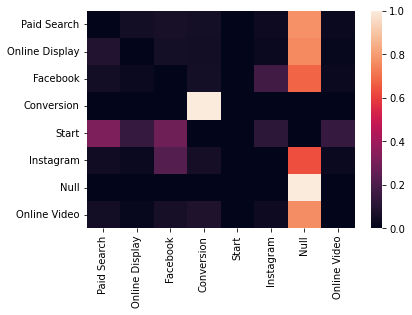

In [136]:
p1 = sns.heatmap(trans_matrix)

In [129]:
def removal_effects(df, conversion_rate):
    removal_effects_dict = {}
    channels = [channel for channel in df.columns if channel not in ['Start',
                                                                     'Null',
                                                                     'Conversion']]
    for channel in channels:
        removal_df = df.drop(channel, axis=1).drop(channel, axis=0)
        for column in removal_df.columns:
            row_sum = np.sum(list(removal_df.loc[column]))
            null_pct = float(1) - row_sum
            if null_pct != 0:
                removal_df.loc[column]['Null'] = null_pct
            removal_df.loc['Null']['Null'] = 1.0


        removal_to_conv = removal_df[
            ['Null', 'Conversion']].drop(['Null', 'Conversion'], axis=0)
        removal_to_non_conv = removal_df.drop(
            ['Null', 'Conversion'], axis=1).drop(['Null', 'Conversion'], axis=0)

        removal_inv_diff = np.linalg.inv(
            np.identity(
                len(removal_to_non_conv.columns)) - np.asarray(removal_to_non_conv))
        removal_dot_prod = np.dot(removal_inv_diff, np.asarray(removal_to_conv))
        removal_cvr = pd.DataFrame(removal_dot_prod,
                                   index=removal_to_conv.index)[[1]].loc['Start'].values[0]
        removal_effect = 1 - removal_cvr / conversion_rate
        removal_effects_dict[channel] = removal_effect

    return removal_effects_dict


removal_effects_dict = removal_effects(trans_matrix, base_conversion_rate)

In [123]:
def markov_chain_allocations(removal_effects, total_conversions):
    re_sum = np.sum(list(removal_effects.values()))

    return {k: (v / re_sum) * total_conversions for k, v in removal_effects.items()}


attributions = markov_chain_allocations(removal_effects_dict, total_conversions)

In [140]:
attributions

{'Paid Search': 4618.891257291355,
 'Online Display': 2153.2469267590836,
 'Facebook': 4948.892177847522,
 'Instagram': 3031.5215485558924,
 'Online Video': 2886.448089546147}

In [207]:
data_items = attributions.items()
data_list = list(data_items)

df_attr = pd.DataFrame(data_list)
df_attr.rename(columns={0: 'Channels', 1: 'Conversions'}, inplace=True)

In [208]:
df_attr

,Channels,Conversions
0,Paid Search,4618.891257
1,Online Display,2153.246927
2,Facebook,4948.892178
3,Instagram,3031.521549
4,Online Video,2886.448090


In [209]:
data_items = dict2.items()
data_list = list(data_items)

df_lt = pd.DataFrame(data_list)
df_lt.rename(columns={0: 'Channels', 1: 'LT_Conversions'}, inplace=True)

In [211]:
MTA_LT_df = df_attr.merge(df_lt, on='Channels')

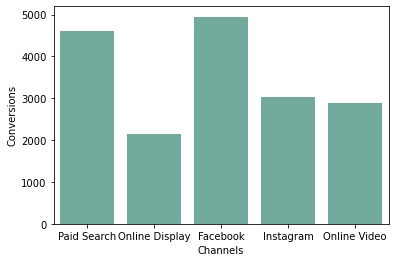

In [149]:
sns.barplot(
    x="Channels", 
    y="Conversions", 
    data=df_attr, 
    estimator=sum, 
    ci=None, 
    color='#69b3a2');

In [212]:
MTA_LT_df

,Channels,Conversions,LT_Conversions
0,Paid Search,4618.891257,4736
1,Online Display,2153.246927,2144
2,Facebook,4948.892178,4690
3,Instagram,3031.521549,2868
4,Online Video,2886.448090,3201


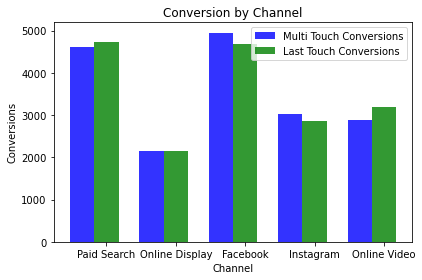

In [226]:

import matplotlib.pyplot as plt

# data to plot
n_groups = len(MTA_LT_df)
conv = MTA_LT_df['Conversions']
LTconv = MTA_LT_df['LT_Conversions']

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8

rects1 = plt.bar(index, conv, bar_width,
alpha=opacity,
color='b',
label='Multi Touch Conversions')

rects2 = plt.bar(index + bar_width, LTconv, bar_width,
alpha=opacity,
color='g',
label='Last Touch Conversions')

plt.xlabel('Channel')
plt.ylabel('Conversions')
plt.title('Conversion by Channel')
plt.xticks(index + bar_width, list(MTA_LT_df['Channels']))
plt.legend()

plt.tight_layout()
plt.show()